## Introduction

This project builds a probabilistic early-warning model for US recessions using macroeconomic indicators. The model estimates the probability of an NBER-defined recession occurring within the next six months. The focus is on interpretable macro signals and early-warning performance rather than point-prediction accuracy.

## Data

The analysis uses publicly available U.S. macroeconomic data from FRED (Federal Reserve Economic Data). All series are converted to a monthly frequency to ensure consistency across variables. Daily financial series, such as Treasury yields, are aggregated to monthly averages, while other indicators are reported at a monthly frequency by construction.

The sample spans the early 1970s through the present, covering multiple business cycles and recession episodes. The outcome variable is based on the NBER recession indicator, which serves as the benchmark definition of U.S. recessions.

The dataset includes the following variables:

- Treasury yields at different maturities (10-year, 2-year, 3-month)

- Federal funds rate

- Unemployment rate

- Consumer Price Index (CPI)

- Industrial production

- Credit spread proxy

- Recession indicator

Missing observations due to release timing are handled using forward-filling, reflecting the information that would have been available to forecasters at the time. This approach ensures a continuous monthly dataset suitable for time-series modeling.

In [59]:
from matplotlib import pyplot as plt
import pandas as pd
from pandas_datareader import data as web

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

start = "1970-01-01"
end = None

series = ["USREC", "DGS10", "DGS2", "TB3MS", "BAA", "UNRATE", "CPIAUCSL", "FEDFUNDS", "INDPRO"]

df = web.DataReader(series, "fred", start, end)



# Convert daily yields to monthly average; others are already monthly
monthly = df.resample("ME").mean()

# Target: recession status 6 months ahead
monthly["target_rec_6m_ahead"] = monthly["USREC"].shift(-6)







## Feature Engineering

Raw macroeconomic series are transformed into economically meaningful features designed to capture financial conditions, labor market dynamics, inflationary pressures, real activity, and monetary policy stance. Feature construction is guided by standard macroeconomic intuition and prior empirical evidence on recession predictors.

Key engineered features include:

- Yield curve slopes (10-year minus 2-year; 10-year minus 3-month), which capture expectations of future economic activity and monetary policy

- Credit spread proxy, reflecting tightening financial conditions and risk aversion

- Unemployment rate changes over short and medium horizons, capturing labor market deterioration

- Year-over-year inflation, measuring price dynamics and demand conditions

- Industrial production growth (year-over-year), capturing real economic activity

- Federal funds rate level and spreads, proxying for monetary policy tightness

Year-over-year growth rates and multi-month changes are used to reduce noise and emphasize cyclical movements. All features are standardized prior to model estimation to ensure comparability of coefficients and numerical stability.

These transformations aim to balance interpretability with predictive content, allowing the model to reflect well-understood macroeconomic mechanisms rather than purely statistical relationships.

In [60]:

# Yield curve slope
monthly["term_spread_10y_2y"] = monthly["DGS10"] - monthly["DGS2"]

monthly_ffill = monthly.sort_index().ffill()

m = monthly_ffill.copy()


# Inflation (YoY % change)
m["infl_yoy"] = 100 * (m["CPIAUCSL"].pct_change(12))

# Unemployment change
m["unrate_chg_3m"] = m["UNRATE"] - m["UNRATE"].shift(3)
m["unrate_chg_12m"] = m["UNRATE"] - m["UNRATE"].shift(12)

# Industrial production growth (YoY)
m["indpro_yoy"] = 100 * (m["INDPRO"].pct_change(12))

# Rate level + spread features
m["ffunds_level"] = m["FEDFUNDS"]
m["spread_10y_ff"] = m["DGS10"] - m["FEDFUNDS"]   # rough stance / term premium proxy
m["term_spread_10y_3m"] = m["DGS10"] - m["TB3MS"]
m["credit_spread_baa_10y"] = m["BAA"] - m["DGS10"]

# Short-rate slope proxy (2y - ff)
m["spread_2y_ff"] = m["DGS2"] - m["FEDFUNDS"]

feature_cols = [
    "term_spread_10y_2y",
    "term_spread_10y_3m",
    "credit_spread_baa_10y",
    "infl_yoy",
    "unrate_chg_3m",
    "unrate_chg_12m",
    "indpro_yoy",
    "ffunds_level",
    "spread_10y_ff",
    "spread_2y_ff",
]

model_df = m[feature_cols + ["target_rec_6m_ahead"]].dropna()

X = model_df[feature_cols]
y = model_df["target_rec_6m_ahead"].astype(int)

#Time-based train/test split

split_date = "2005-01-01"

X_train = X.loc[X.index < split_date]
X_test  = X.loc[X.index >= split_date]

y_train = y.loc[y.index < split_date]
y_test  = y.loc[y.index >= split_date]


#Standardize Features

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)



## Model and Evaluation

To estimate recession risk, the project employs a logistic regression model, which is well-suited for probabilistic binary outcomes and allows for transparent interpretation of macroeconomic signals. The model estimates the probability that the U.S. economy will enter an NBER-defined recession within the next six months based on contemporaneous macroeconomic and financial indicators.

All input features are standardized to ensure comparability of coefficients and stable optimization. The feature set includes yield curve slopes, credit conditions, labor market dynamics, inflation, real activity, and monetary policy indicators, reflecting commonly cited drivers of business cycle fluctuations.

A time-based train/test split is used to mimic real-time forecasting conditions. Observations prior to January 2005 are used for training, while later observations are reserved for out-of-sample evaluation. No shuffling is performed to avoid look-ahead bias.

In [61]:

#Fit Logistic Regression

logit = LogisticRegression(
    C=1.0,
    max_iter=1000,
    class_weight="balanced"
)

logit.fit(X_train_scaled, y_train)

#Evaluate with ROC/AUC

y_prob = logit.predict_proba(X_test_scaled)[:, 1]

auc = roc_auc_score(y_test, y_prob)

#Confusion Matrix

y_pred = (y_prob >= 0.5).astype(int)

confusion_matrix(y_test, y_pred)



array([[155,  77],
       [ 15,   5]])

In [62]:
#Interpret Coefficients

coef_df = pd.Series(
    logit.coef_[0],
    index=X.columns
).sort_values()

for t in [0.2, 0.25, 0.3]:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    print(f"threshold={t} | TP={tp}, FP={fp}, FN={fn}")




threshold=0.2 | TP=11, FP=103, FN=9
threshold=0.25 | TP=8, FP=97, FN=12
threshold=0.3 | TP=6, FP=92, FN=14


## Results

The model’s predicted recession probability responds strongly to changes in financial and macroeconomic conditions. In particular, yield curve inversion and widening credit spreads are associated with sustained increases in estimated recession risk, while stronger real activity and a steeper yield curve correspond to lower predicted probabilities. These relationships are consistent with established macroeconomic theory.

Incorporating additional financial indicators increases the model’s sensitivity to emerging downturns. As a result, the model identifies a larger share of recession episodes in advance, reflected in higher true positive rates and fewer missed recessions. However, this increased sensitivity also leads to a higher number of false positives, as elevated risk persists during some late-expansion periods that do not culminate in an immediate recession.

This tradeoff highlights the intended use of the model as an early-warning and risk-monitoring tool rather than a precise timing device. Lower probability thresholds (approximately 20–25%) improve recession detection at the cost of additional false alarms, which is appropriate in settings where the costs of missing a recession exceed the costs of issuing early warnings.

Overall, the results suggest that incorporating financial conditions improves recession risk assessment by prioritizing earlier detection, even when this comes at the expense of increased false positives.


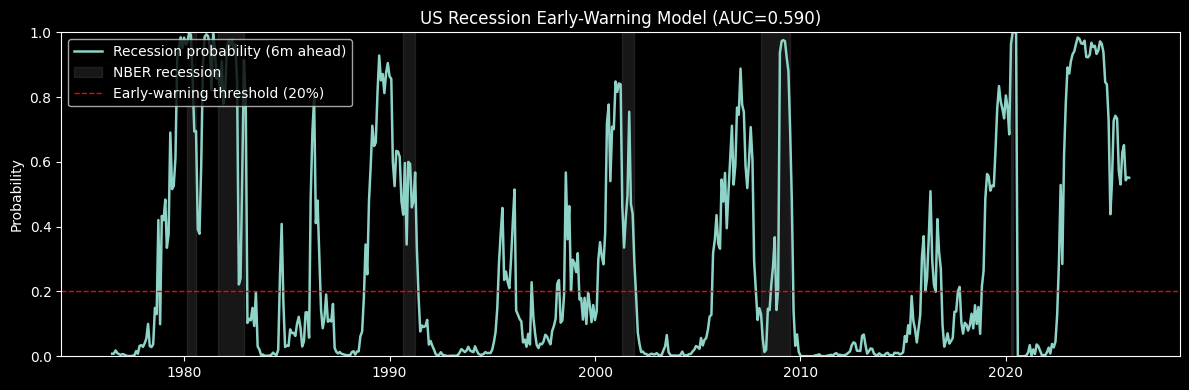

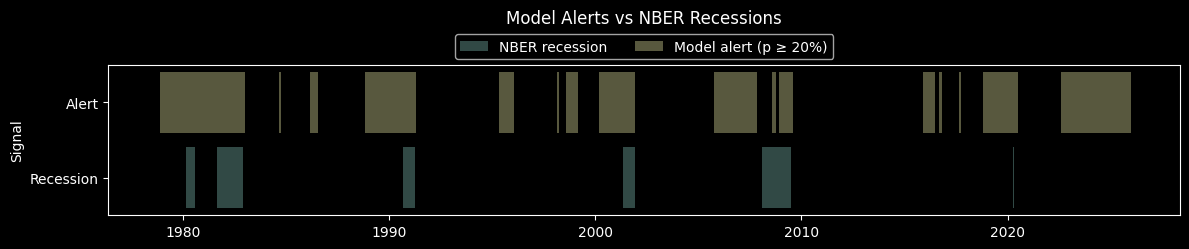

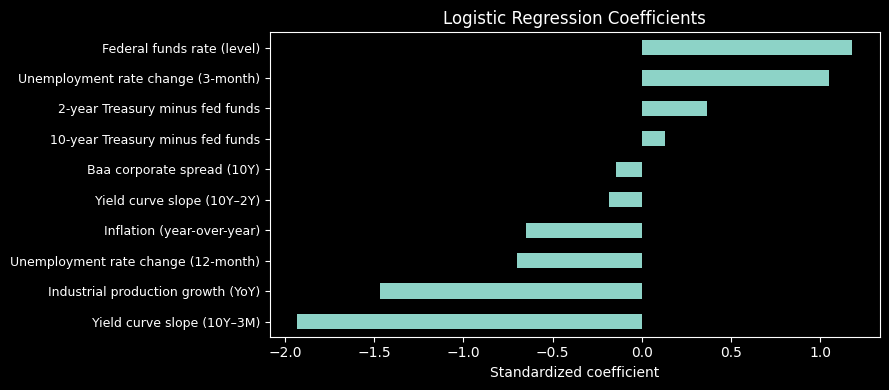

In [77]:
# Full-sample predicted probabilities
probs_full = logit.predict_proba(
    scaler.transform(X)
)[:, 1]

prob_series = pd.Series(probs_full, index=X.index)


#Plot recession probability over time

plt.figure(figsize=(12,4))

plt.plot(
    prob_series,
    label="Recession probability (6m ahead)",
    linewidth=1.8
)

recession_mask = (
    monthly["USREC"]
    .reindex(prob_series.index)
    .fillna(0)
    .astype(bool)
)

plt.fill_between(
    prob_series.index,
    0,
    1,
    where=recession_mask,
    color="gray",
    alpha=0.18,
    label="NBER recession"
)

plt.axhline(
    0.2,
    color="red",
    linestyle="--",
    linewidth=1,
    label="Early-warning threshold (20%)"
)

plt.title(f"US Recession Early-Warning Model (AUC={auc:.3f})")
plt.ylim(0, 1)
plt.ylabel("Probability")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# Binary alert visualization showing periods where predicted recession risk
# exceeds the early-warning threshold, compared with NBER recession dates
threshold = 0.20

idx = prob_series.index
usrec = monthly["USREC"].reindex(idx).fillna(0).astype(int)
alert = (prob_series >= threshold).astype(int)

plt.figure(figsize=(12, 2.6))

plt.fill_between(
    idx, 0.00, 0.45,
    where=(usrec == 1),
    step="post",
    alpha=0.35,
    label="NBER recession"
)

plt.fill_between(
    idx, 0.55, 1.00,
    where=(alert == 1),
    step="post",
    alpha=0.35,
    label=f"Model alert (p ≥ {int(threshold*100)}%)"
)

plt.ylim(-0.05, 1.05)
plt.yticks([0.225, 0.775], ["Recession", "Alert"])
plt.title("Model Alerts vs NBER Recessions", pad=30)
plt.ylabel("Signal")
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    frameon=True
)
plt.tight_layout()
plt.show()

#Logistic Regression

pretty_labels = {
    "ffunds_level": "Federal funds rate (level)",
    "unrate_chg_3m": "Unemployment rate change (3-month)",
    "spread_2y_ff": "2-year Treasury minus fed funds",
    "spread_10y_ff": "10-year Treasury minus fed funds",
    "credit_spread_baa_10y": "Baa corporate spread (10Y)",
    "term_spread_10y_2y": "Yield curve slope (10Y–2Y)",
    "infl_yoy": "Inflation (year-over-year)",
    "unrate_chg_12m": "Unemployment rate change (12-month)",
    "indpro_yoy": "Industrial production growth (YoY)",
    "term_spread_10y_3m": "Yield curve slope (10Y–3M)",
}
coef_df_pretty = coef_df.rename(index=pretty_labels)
plt.figure(figsize=(9, 4))
plt.tick_params(axis="y", labelsize=9)
coef_df_pretty.sort_values().plot(kind="barh")
plt.title("Logistic Regression Coefficients")
plt.xlabel("Standardized coefficient")
plt.tight_layout()
plt.show()


## Interpretation (6-month horizon)

The model’s predicted recession probability responds meaningfully to changes in macroeconomic and financial conditions. In particular, periods of yield curve flattening or inversion and widening credit spreads are associated with elevated recession risk, while stronger real activity and a steeper yield curve correspond to lower predicted probabilities. These relationships are consistent with established macroeconomic theory and historical evidence. The estimated logistic regression coefficients reinforce this interpretation, with tighter monetary policy, rising unemployment, and widening credit spreads associated with higher recession risk, while a steeper yield curve and stronger industrial production growth are associated with lower risk.

The probability-based framework highlights gradual increases in recession risk rather than abrupt binary signals. As economic conditions deteriorate, the model raises recession probabilities well in advance of several major downturns, including the early 1980s recessions, the Global Financial Crisis, and the COVID-19 recession. This behavior supports the use of the model as an early-warning indicator rather than a precise timing tool.

Because recessions are rare events, a conventional 50 percent classification threshold is overly conservative. Using a lower early-warning threshold, approximately 20 to 25 percent, increases detection at the cost of additional false positives. This tradeoff is appropriate in macroeconomic monitoring contexts, where the costs of missing a recession often exceed the costs of issuing false alarms.

The alert timeline highlights that some recession warnings persist beyond the officially dated NBER recession windows, most notably in 2020. This reflects the model’s focus on elevated economic risk rather than the duration of realized downturns, as the COVID-19 recession was unusually short while financial uncertainty and stress remained high.

Overall, the model demonstrates that incorporating financial conditions, particularly yield curve slopes and credit spreads, improves recession risk assessment and provides economically interpretable signals that are useful for monitoring cyclical turning points.

## Limitations

Several limitations should be noted when interpreting the results. First, recessions are rare events, which inherently limits predictive performance and leads to imbalanced classification outcomes. As a result, performance metrics such as ROC/AUC should be interpreted as measures of relative risk ranking rather than precise forecasting accuracy.

Second, the analysis relies on revised historical data rather than real-time data vintages. In practice, macroeconomic data are subject to revisions, and real-time forecasting performance may differ from results obtained using final data releases.

Third, the COVID-19 recession represents a structural break driven by non-economic shocks, which may distort model estimates and exaggerate predicted risk during that period. More flexible models or explicit shock controls would be required to address such events fully.

Finally, the logistic regression framework is inherently linear and may not capture nonlinear interactions between macroeconomic variables. While this choice supports interpretability, alternative nonlinear models could potentially improve predictive performance at the cost of transparency.


## Conclusions

This project develops a probabilistic early-warning model for U.S. recessions using macroeconomic and financial indicators. By focusing on recession risk rather than point forecasts of economic growth, the analysis emphasizes interpretability, proper time-series evaluation, and the tradeoff between early detection and false alarms.

The results show that incorporating financial conditions, particularly yield curve slopes and credit spread proxies, improves the model’s ability to identify periods of elevated recession risk. While overall predictive performance remains modest, with an out-of-sample ROC/AUC of approximately 0.59, this level of performance is consistent with the inherent difficulty of forecasting rare macroeconomic events. Importantly, the model captures economically meaningful risk dynamics and raises recession probabilities ahead of several major downturns.

Threshold analysis highlights that lower probability cutoffs, approximately 20 to 25 percent, substantially improve recession detection at the cost of increased false positives. This tradeoff reinforces the interpretation of the model as a risk-monitoring and early-warning tool rather than a precise timing device. In such settings, sustained increases in estimated risk are often more informative than binary predictions.

Overall, the project demonstrates that relatively simple and interpretable models, when combined with economically motivated features and appropriate evaluation methods, can provide useful insights into cyclical risk. Future extensions could incorporate real-time data vintages, alternative target definitions, or nonlinear modeling approaches to further enhance early-warning performance.